In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as kr

BATCH = 128
EPOCHS = 20
PATIENCE = 5
SEED = 57
NUM_CLASSES = 10
INPUT_SHAPE = (224, 224)

DATA_DIR = '/content/drive/MyDrive/datasets/10_monkey'

In [3]:
!ls /content/drive/MyDrive/datasets/10_monkey

training  validation


In [4]:
ds_train = kr.utils.image_dataset_from_directory(DATA_DIR+'/training', batch_size=BATCH, image_size=INPUT_SHAPE, shuffle=True, seed=SEED)
ds_validation = kr.utils.image_dataset_from_directory(DATA_DIR+'/validation', batch_size=BATCH, image_size=INPUT_SHAPE)

Found 1097 files belonging to 10 classes.
Found 272 files belonging to 10 classes.


In [17]:
ds_train.class_names, ds_validation.class_names

(['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'],
 ['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9'])

In [5]:
def show_batch(batch):
  plt.figure(figsize=(10, 10))
  for images, labels in batch:
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.title(ds_train.classes[labels[i]])
          plt.axis("off")

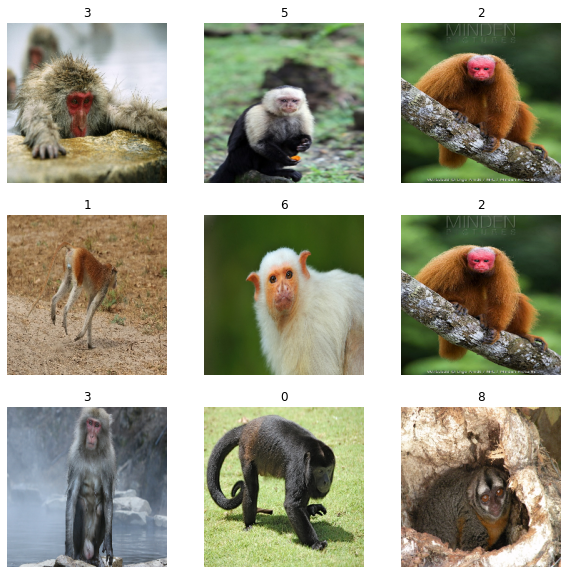

In [6]:
show_batch(ds_train.take(1))

In [7]:
def get_model(num_classes):
  base_model = kr.applications.ResNet50V2(weights='imagenet', include_top=False)
  base_model.trainable = False
  model = kr.models.Sequential([
      kr.layers.Input(INPUT_SHAPE + (3,)),
      kr.layers.Rescaling(1/255.0),
      kr.layers.RandomFlip('horizontal'),
      kr.layers.RandomRotation(0.1),
      base_model,
      kr.layers.Flatten(),
      kr.layers.Dense(1024, activation='relu'),
      kr.layers.Dropout(0.2),
      kr.layers.Dense(num_classes, activation='softmax')
  ])
  return model

In [8]:
model = get_model(NUM_CLASSES)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                        

In [10]:
early_stopping = kr.callbacks.EarlyStopping(monitor='val_accuracy', patience=PATIENCE, restore_best_weights=True)

In [11]:
model.compile(optimizer=kr.optimizers.Adam(learning_rate=0.001), loss=kr.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [12]:
model.fit(ds_train, epochs=EPOCHS, shuffle=True, batch_size=BATCH, verbose=True, validation_data=ds_validation, callbacks=[early_stopping])

Epoch 1/20
9/9 [==============================] - 32s 1s/step - loss: 40.9296 - accuracy: 0.5014 - val_loss: 7.5349 - val_accuracy: 0.7647
Epoch 2/20
9/9 [==============================] - 21s 1s/step - loss: 4.5958 - accuracy: 0.8806 - val_loss: 2.0565 - val_accuracy: 0.9375
Epoch 3/20
9/9 [==============================] - 20s 891ms/step - loss: 2.0266 - accuracy: 0.9325 - val_loss: 1.2208 - val_accuracy: 0.9559
Epoch 4/20
9/9 [==============================] - 20s 871ms/step - loss: 0.7069 - accuracy: 0.9681 - val_loss: 1.5164 - val_accuracy: 0.9596
Epoch 5/20
9/9 [==============================] - 20s 836ms/step - loss: 0.4836 - accuracy: 0.9763 - val_loss: 1.0450 - val_accuracy: 0.9596
Epoch 6/20
9/9 [==============================] - 19s 833ms/step - loss: 0.3067 - accuracy: 0.9772 - val_loss: 0.9169 - val_accuracy: 0.9596
Epoch 7/20
9/9 [==============================] - 20s 897ms/step - loss: 0.2004 - accuracy: 0.9863 - val_loss: 1.2921 - val_accuracy: 0.9632
Epoch 8/20
9/9 [==

In [42]:
model.evaluate(ds_validation)

3/3 [==============================] - 4s 200ms/step - loss: 1.3165 - accuracy: 0.9706


[1.3164780139923096, 0.970588207244873]

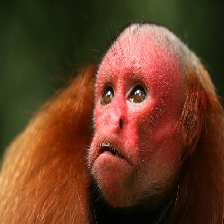

In [21]:
image = kr.utils.load_img('/content/drive/MyDrive/datasets/10_monkey/validation/n2/n2010.jpg', target_size=INPUT_SHAPE)
image

In [36]:
image_np = np.array(image)
image_np.shape

(224, 224, 3)

In [38]:
image_exp = tf.expand_dims(image_np, axis=0)

In [41]:
pred = model.predict(image_exp)
pred = np.argmax(pred)
ds_validation.class_names[pred]

'n2'